In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils


from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


import string
alphabet = list(string.ascii_lowercase)
          

## Data

Data for this is from https://gmd.copernicus.org/articles/11/1133/2018/ CDRMIP data, where pi-CO2pulse is the 100GtC pulse and piControl is the control

In [2]:
G_ds = xr.open_dataset('Outputs/G_internal_var_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_ds = xr.open_dataset('Outputs/G_cdr_internal_var_ds.nc4')['__xarray_dataarray_variable__']

In [ ]:
G_ds = xr.concat([G_ds, -G_cdr_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_ds.name = 'G[tas]'

In [ ]:
A = utils.A

In [ ]:
model_color = utils.model_color

In [ ]:
mean_intramod = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).mean(dim = 'pulse_type').mean(dim = 'model').load()
std_intramod = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).mean(dim = 'pulse_type').std(dim = 'model').load()

In [ ]:
mean_intern = {}
for m in  G_ds.model.values:
    mean_intern[m] = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').mean(dim = 'pulse_year').load()
std_intern = {}
for m in  G_ds.model.values:
    std_intern[m] = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').std(dim = 'pulse_year').load()
    

In [ ]:
mean_intramod_type = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).mean(dim = 'model').load()
std_intramod_type = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).std(dim = 'model').load()

In [ ]:
mean_intern_type = {}
for m in  G_ds.model.values:
    mean_intern_type[m] = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_year').load()
std_intern_type = {}
for m in  G_ds.model.values:
    std_intern_type[m] = G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).std(dim = 'pulse_year').load()
    

## Global Mean plots

m = 'GFDL'
fig, ax = plt.subplots()
G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').sel(pulse_year = 0).plot()
ax.fill_between(np.arange(0,len(G_ds['year'])),
                 G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').mean(dim = 'pulse_year') + G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').std(dim = 'pulse_year'),
                 G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').mean(dim = 'pulse_year') + G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').std(dim = 'pulse_year'), color = 'grey', alpha = 0.2)
ax.fill_between(np.arange(0,len(G_ds.sel(model = m)['year'])),
        G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).mean(dim = 'pulse_type').mean(dim = 'model') + G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).mean(dim = 'pulse_type').std(dim = 'model'),
        G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).mean(dim = 'pulse_type').mean(dim = 'model') + G_ds.weighted(A).mean(dim = ['lat','lon']).sel(pulse_year = 0).mean(dim = 'pulse_type').std(dim = 'model'), color = 'khaki', alpha = 0.2)


UKESM1_r1
MIROC
NORESM2
ACCESS
GFDL
CANESM5_r1p2
CANESM5_r2p2
CANESM5_r3p2


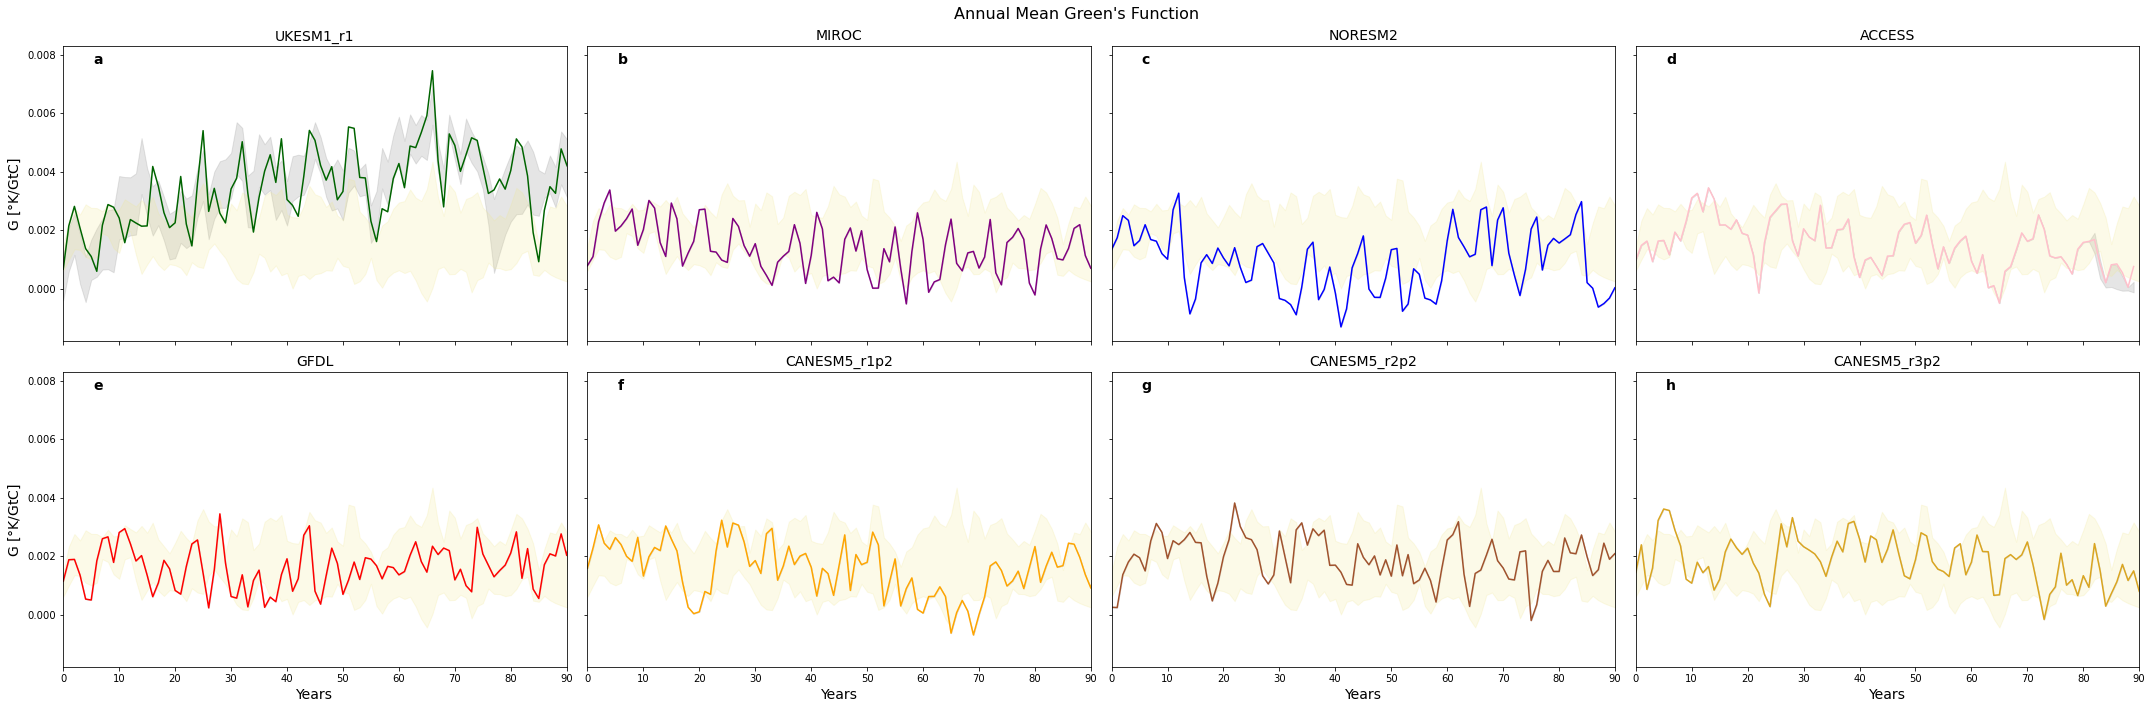

In [15]:
fig, axes = plt.subplots(2,4,figsize = [30,10], sharey = True, sharex = True)
alpha_labels = iter(alphabet)

plt.suptitle('Annual Mean Green\'s Function', fontsize = 16)
for ax, m in zip(axes.ravel(), G_ds.model.values):
    print(m)
    G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).mean(dim = 'pulse_type').sel(pulse_year = 0).plot(ax = ax, color = model_color[m])
    
    ax.set_xlim(G_ds.year.min(), G_ds.year[150].values)
    ax.set_title(m, fontsize = 14)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

    ax.fill_between(np.arange(0,len(G_ds.sel(model = m)['year'])), mean_intern[m]-std_intern[m], mean_intern[m]+std_intern[m], color = 'grey', alpha = 0.2)
    ax.fill_between(np.arange(0,len(G_ds.sel(model = m)['year'])), mean_intramod - std_intramod, mean_intramod + std_intramod, color = 'khaki', alpha = 0.2)
    ax.set_xlim(0,90)
    
axes[0,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
axes[1,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
for idx in [0,1,2,3]:
    axes[1,idx].set_xlabel('Years', fontsize = 14)


####### legend ##########
plt.tight_layout()
plt.savefig('figures/paper/supp_GF_internal_var_model_spread.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
fig, axes = plt.subplots(2,4,figsize = [30,10], sharey = True, sharex = True)
alpha_labels = iter(alphabet)

plt.suptitle('Annual Mean Green\'s Function', fontsize = 16)
for ax, m in zip(axes.ravel(), G_ds.model.values):
    print(m)
    G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).sel(pulse_type = 'pulse').sel(pulse_year = 0).plot(ax = ax, color = model_color[m])
    
    ax.set_xlim(G_ds.year.min(), G_ds.year[150].values)
    ax.set_title(m, fontsize = 14)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

    ax.fill_between(np.arange(0,len(G_ds.sel(model = m)['year'])), 
                    (mean_intern_type[m]-2*std_intern_type[m]).sel(pulse_type = 'pulse'), 
                    (mean_intern_type[m]+2*std_intern_type[m]).sel(pulse_type = 'pulse'), 
                    color = 'grey', alpha = 0.2)
    ax.fill_between(np.arange(0,len(G_ds.sel(model = m)['year'])), 
                    (mean_intramod_type - 2*std_intramod_type).sel(pulse_type = 'pulse'), 
                    (mean_intramod_type + 2*std_intramod_type).sel(pulse_type = 'pulse'), 
                    color = 'khaki', alpha = 0.2)
    
    ax.set_xlim(0,90)
    
axes[0,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
axes[1,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
for idx in [0,1,2,3]:
    axes[1,idx].set_xlabel('Years', fontsize = 14)


####### legend ##########
plt.tight_layout()
plt.savefig('figures/paper/supp_GF_internal_var_model_spread_pulse.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
fig, axes = plt.subplots(2,4,figsize = [30,10], sharey = True, sharex = True)
alpha_labels = iter(alphabet)

plt.suptitle('Annual Mean Green\'s Function', fontsize = 16)
for ax, m in zip(axes.ravel(), G_ds.model.values):
    print(m)
    G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).sel(pulse_type = 'cdr').sel(pulse_year = 0).plot(ax = ax, color = model_color[m])
    
    ax.set_xlim(G_ds.year.min(), G_ds.year[150].values)
    ax.set_title(m, fontsize = 14)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

    ax.fill_between(np.arange(0,len(G_ds.sel(model = m)['year'])), 
                    (mean_intern_type[m]-2*std_intern_type[m]).sel(pulse_type = 'cdr'), 
                    (mean_intern_type[m]+2*std_intern_type[m]).sel(pulse_type = 'cdr'), 
                    color = 'grey', alpha = 0.2)
    ax.fill_between(np.arange(0,len(G_ds.sel(model = m)['year'])), 
                    (mean_intramod_type - 2*std_intramod_type).sel(pulse_type = 'cdr'), 
                    (mean_intramod_type + 2*std_intramod_type).sel(pulse_type = 'cdr'), 
                    color = 'khaki', alpha = 0.2)
    
    ax.set_xlim(0,90)
    
axes[0,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
axes[1,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
for idx in [0,1,2,3]:
    axes[1,idx].set_xlabel('Years', fontsize = 14)


####### legend ##########
plt.tight_layout()
plt.savefig('figures/paper/supp_GF_internal_var_model_spread_cdr.png', bbox_inches = 'tight', dpi = 300)

## Spatial Plots

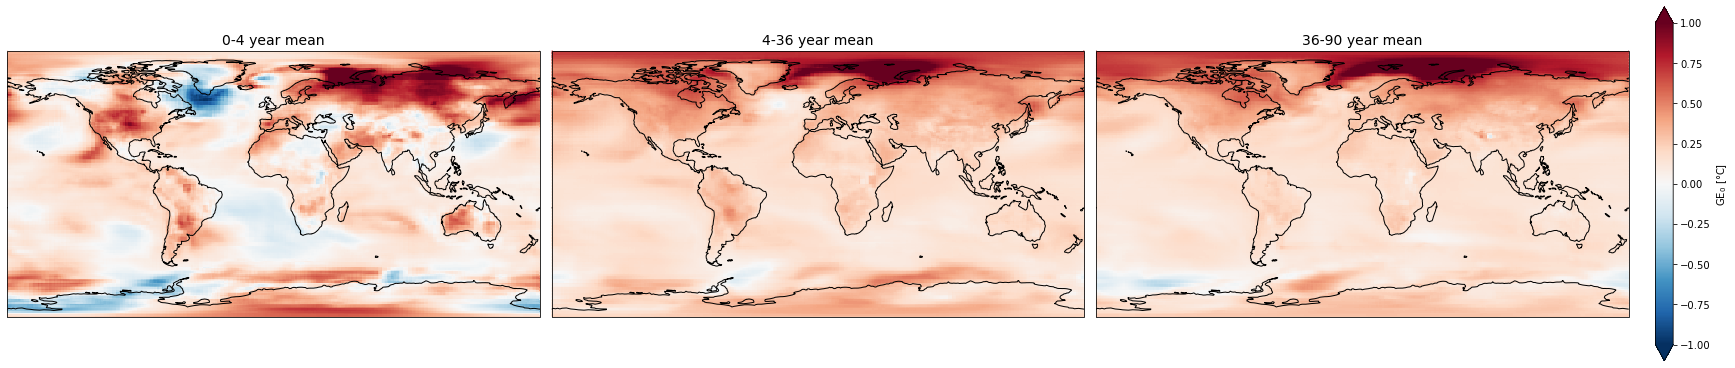

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [24,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout=True)
(G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year').plot(ax = ax0, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r', add_colorbar = False)
ax0.set_title('0-4 year mean', fontsize = 14)
ax0.coastlines()
(G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year').plot(ax = ax1, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r', add_colorbar = False)
ax1.set_title('4-36 year mean', fontsize = 14)
ax1.coastlines()

(G_ds.mean(dim = ['model'])*100).isel(year = slice(36,90)).mean(dim = 'year').plot(ax = ax2, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax2.set_title('36-90 year mean', fontsize = 14)
ax2.coastlines()


plt.savefig('figures/paper/GF_time_varying_long.png', bbox_inches = 'tight', dpi = 350)

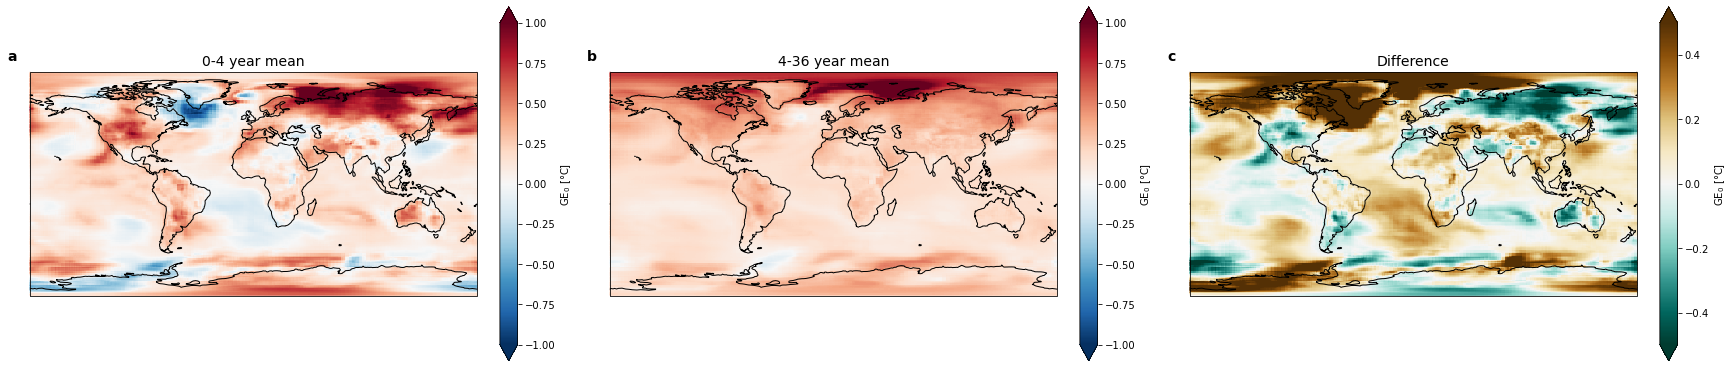

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [24,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout=True)
alpha_labels = iter(alphabet)

(G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year').plot(ax = ax0, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax0.set_title('0-4 year mean', fontsize = 14)
ax0.coastlines()
(G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year').plot(ax = ax1, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'RdBu_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax1.set_title('4-36 year mean', fontsize = 14)
ax1.coastlines()

((G_ds.mean(dim = ['model'])*100).isel(year = slice(4,36)).mean(dim = 'year') - 
 (G_ds.mean(dim = ['model'])*100).isel(year = slice(0,4)).mean(dim = 'year')).plot(ax = ax2, vmax = 0.5, vmin = -0.5, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'BrBG_r',
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax2.set_title('Difference', fontsize = 14)
ax2.coastlines()

for ax in [ax0,ax1,ax2]:
    label = next(alpha_labels)
    ax.text(x = -0.05, y =1.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig('figures/paper/GF_time_varying.png', bbox_inches = 'tight', dpi = 350)